In [76]:
!pip install pulp
from pulp import *
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [0]:
#!{sys.executable} -m pip install xlrd

# Importing the dataset

In [78]:
df = pd.read_excel("openfoodfacts_simplified_database.xlsx")
df = df[~df['nutrition_grade_fr'].isna()]
df['nutrition_grade_fr'].describe()

count     5925
unique       5
top          d
freq      1599
Name: nutrition_grade_fr, dtype: object

In [79]:
cols = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 'nutrition_grade_fr']
df = df[cols]
df.columns = ['energy', 'saturated_fat', 'sugars', 'fiber', 'proteins', 'salt', 'nutriscore']
df.head()

,energy,saturated_fat,sugars,fiber,proteins,salt,nutriscore
0,590.0,0.5,5.5,1.8,6.2,0.236,b
3,1477.0,1.5,10.0,9.9,5.4,2.200,b
4,176.0,0.0,9.7,0.0,0.5,0.000,c
8,1022.0,1.9,0.5,1.4,12.0,0.332,b
9,196.0,0.0,11.0,0.5,0.7,0.040,c


In [0]:
df = df[~df['energy'].isna()]
df = df[~df['saturated_fat'].isna()]
df = df[~df['sugars'].isna()]
df = df[~df['fiber'].isna()]
df = df[~df['proteins'].isna()]
df = df[~df['salt'].isna()]

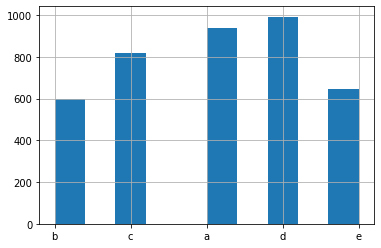

In [81]:
df['nutriscore'].hist()

In [0]:
def create_buckets(df, criterion, precision, eps):
    num_buckets = int((df[criterion].max() + eps - df[criterion].min()) / precision)
    max_value = df[criterion].max() + eps
    min_value = df[criterion].min()
    real_precision = (max_value - min_value) / num_buckets
    
    buckets = []
    left_thresh = min_value
    for i in range(num_buckets):
        buckets.append((left_thresh, left_thresh+real_precision))
        left_thresh = left_thresh+real_precision

    return buckets

In [0]:
buckets = {}

37


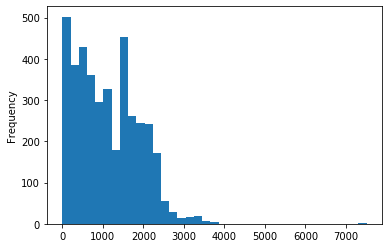

In [84]:
bins = int((df['energy'].max() - df['energy'].min()) / 200)
print(bins)
df['energy'].plot.hist(bins=bins)

50


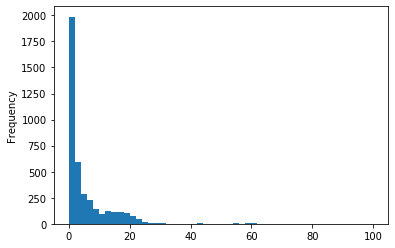

In [85]:
bins = int((df['saturated_fat'].max() - df['saturated_fat'].min()) / 2)
print(bins)
df['saturated_fat'].plot.hist(bins=bins)

25


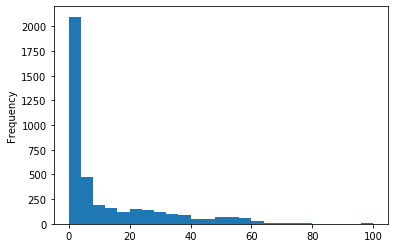

In [86]:
bins = int((df['sugars'].max() - df['sugars'].min()) / 4)
print(bins)
df['sugars'].plot.hist(bins=bins)

68


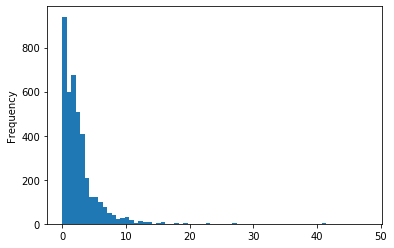

In [87]:
bins = int((df['fiber'].max() - df['fiber'].min()) / 0.7)
print(bins)
df['fiber'].plot.hist(bins=bins)

20


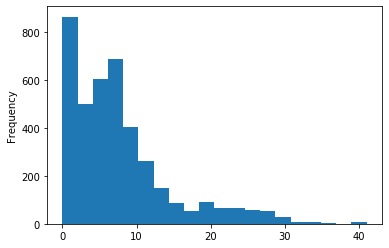

In [88]:
bins = int((df['proteins'].max() - df['proteins'].min()) / 2)
print(bins)
df['proteins'].plot.hist(bins=bins)

97


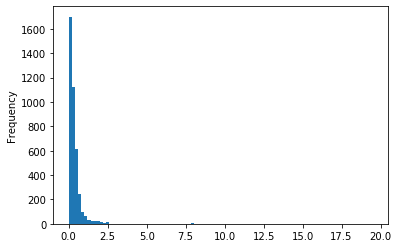

In [89]:
bins = int((df['salt'].max() - df['salt'].min()) / 0.2)
print(bins)
df['salt'].plot.hist(bins=bins)

# Create the buckets

In [0]:
buckets['energy'] = create_buckets(df, 'energy', precision=200, eps=10)
buckets['saturated_fat'] = create_buckets(df, 'saturated_fat', precision=2, eps=0.1)
buckets['sugars'] = create_buckets(df, 'sugars', precision=4, eps=0.1)
buckets['fiber'] = create_buckets(df, 'fiber', precision=0.7, eps=0.1)
buckets['proteins'] = create_buckets(df, 'proteins', precision=2, eps=0.1)
buckets['salt'] = create_buckets(df, 'salt', precision=0.2, eps=0.05)

# Split the dataset

In [0]:
features = ['energy', 'proteins', 'salt', 'fiber', 'saturated_fat', 'sugars']
X = df[features]
y = df[['nutriscore']]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=1)

In [93]:
df = X_train
df['nutriscore'] = y_train['nutriscore']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [94]:
df.count()

energy           199
proteins         199
salt             199
fiber            199
saturated_fat    199
sugars           199
nutriscore       199
dtype: int64

# Formalize the problem

In [95]:
prob = LpProblem("The Nutriscore", LpMinimize)

/usr/local/lib/python3.6/dist-packages/pulp/pulp.py:1137: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [0]:
# Variables measuring differences between two consecutives classes
epsilon = []
epsilon.append(LpVariable("epsilon_1",0, 20))
epsilon.append(LpVariable("epsilon_2",0, 20))
epsilon.append(LpVariable("epsilon_3",0, 20))
epsilon.append(LpVariable("epsilon_4",0, 20))

In [0]:
# The objective function is added to 'prob' first
prob += lpSum(epsilon), "Error in the ranking to be minimized"

In [98]:
epsilon

[epsilon_1, epsilon_2, epsilon_3, epsilon_4]

In [0]:
utility_thresh = {}
for key in buckets:
    utility_thresh[key] = []
    
for key in buckets:    
    for i in range(len(buckets[key])):
        utility_thresh[key].append(LpVariable(key+"_"+str(i), 0, 1))
    utility_thresh[key].append(LpVariable(key+"_"+str(len(buckets[key])), 0, 1))

In [0]:
def get_bucket_index(value, buckets):
    return get_bucket_index_r(value, buckets, 0, len(buckets)-1)

In [0]:
def get_bucket_index_r(value, buckets, left, right):
    middle = int((right - left) / 2 + left)
    if (value >= buckets[middle][0]) and (value < buckets[middle][1]):
        return middle
    if value < buckets[middle][0]:
        return get_bucket_index_r(value, buckets, left, middle-1)
    return get_bucket_index_r(value, buckets, middle+1, right)

In [0]:
def utility_func(df, food_index):
    food = df.loc[food_index]
    criteria = list(food.keys())
    criteria.remove('nutriscore')
    utility = 0
    for criterion in criteria:
        bucket_index = get_bucket_index(food[criterion], buckets[criterion])
        left_thresh = buckets[criterion][bucket_index][0]
        right_thresh = buckets[criterion][bucket_index][1]
        m = (food[criterion] - left_thresh) / (right_thresh - food[criterion])
        left_utility = utility_thresh[criterion][bucket_index]
        right_utility = utility_thresh[criterion][bucket_index+1]
        
        utility += left_utility + m * (right_utility - left_utility)
    
    return utility

In [103]:
df['nutriscore'] = np.where(df['nutriscore']=='a', 5, df['nutriscore'])
df['nutriscore'] = np.where(df['nutriscore']=='b', 4, df['nutriscore'])
df['nutriscore'] = np.where(df['nutriscore']=='c', 3, df['nutriscore'])
df['nutriscore'] = np.where(df['nutriscore']=='d', 2, df['nutriscore'])
df['nutriscore'] = np.where(df['nutriscore']=='e', 1, df['nutriscore'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [104]:
df.head()

,energy,proteins,salt,fiber,saturated_fat,sugars,nutriscore
5220,1632.0,22.0,1.440,1.0,11.0,1.3,1
4823,770.0,11.0,0.400,0.4,0.7,1.6,4
1580,180.0,2.3,0.056,2.3,0.1,6.7,5
6746,490.0,4.1,0.040,0.0,0.7,16.0,4
5630,1482.0,7.4,0.000,1.0,0.2,0.0,5


In [0]:
for index, food in df.iterrows():
    utility_food = utility_func(df, index)
    preceding_foods = df[df['nutriscore'] == food['nutriscore']-1]
    for index2, preceding_food in preceding_foods.iterrows():
        utility_prec_food = utility_func(preceding_foods, index2)
        prob += (utility_food >= 1+utility_prec_food - epsilon[food['nutriscore']-2])

In [0]:
prob += utility_thresh['energy'][len(utility_thresh['energy'])-1] == 0
prob += utility_thresh['saturated_fat'][len(utility_thresh['saturated_fat'])-1] == 0
prob += utility_thresh['sugars'][len(utility_thresh['sugars'])-1] == 0
prob += utility_thresh['salt'][len(utility_thresh['salt'])-1] == 0
prob += utility_thresh['proteins'][0] == 0
prob += utility_thresh['fiber'][0] == 0

In [0]:
prob += utility_thresh['energy'][0] + \
        utility_thresh['saturated_fat'][0] + \
        utility_thresh['sugars'][0] + \
        utility_thresh['salt'][0] + \
        utility_thresh['proteins'][len(utility_thresh['proteins'])-1] + \
        utility_thresh['fiber'][len(utility_thresh['fiber'])-1] == 1

In [0]:
for i in range(len(utility_thresh['energy'])-1):
    prob += utility_thresh['energy'][i] >= utility_thresh['energy'][i+1]
for i in range(len(utility_thresh['saturated_fat'])-1):
    prob += utility_thresh['saturated_fat'][i] >= utility_thresh['saturated_fat'][i+1]
for i in range(len(utility_thresh['sugars'])-1):
    prob += utility_thresh['sugars'][i] >= utility_thresh['sugars'][i+1]
for i in range(len(utility_thresh['salt'])-1):
    prob += utility_thresh['salt'][i] >= utility_thresh['salt'][i+1]

for i in range(len(utility_thresh['proteins'])-1):
    prob += utility_thresh['proteins'][i] <= utility_thresh['proteins'][i+1]
for i in range(len(utility_thresh['fiber'])-1):
    prob += utility_thresh['fiber'][i] <= utility_thresh['fiber'][i+1]



In [109]:
prob.solve()
print("Status:", LpStatus[prob.status])

Status: Optimal


In [110]:
# Each of the variables is printed with it's resolved optimum value
for v in prob.variables():
    print(v.name, "=", v.varValue)

energy_0 = -2.7486466e-15
energy_1 = -2.7140926e-15
energy_10 = -6.6065088e-15
energy_11 = -4.8880576e-15
energy_12 = 2.3276167e-14
energy_13 = 0.0
energy_14 = 0.0
energy_15 = 0.0
energy_16 = 0.0
energy_17 = 0.0
energy_18 = 0.0
energy_19 = 0.0
energy_2 = -2.1753202e-15
energy_20 = 0.0
energy_21 = 0.0
energy_22 = 0.0
energy_23 = 0.0
energy_24 = 0.0
energy_25 = 0.0
energy_26 = 0.0
energy_27 = 0.0
energy_28 = 0.0
energy_29 = 0.0
energy_3 = -6.8655476e-15
energy_30 = 0.0
energy_31 = 0.0
energy_32 = 0.0
energy_33 = 0.0
energy_34 = 0.0
energy_35 = 0.0
energy_36 = 0.0
energy_37 = 0.0
energy_4 = -6.1377303e-15
energy_5 = -5.9955106e-15
energy_6 = 0.0
energy_7 = 7.8457546e-16
energy_8 = 4.8288674e-16
energy_9 = 0.0
epsilon_1 = 1.0
epsilon_2 = 1.0
epsilon_3 = 1.0
epsilon_4 = 1.0
fiber_0 = 0.0
fiber_1 = 0.0
fiber_10 = 0.0
fiber_11 = -3.1378885e-14
fiber_12 = -1.3271013e-14
fiber_13 = 0.0
fiber_14 = 0.0
fiber_15 = 0.0
fiber_16 = 0.0
fiber_17 = 0.0
fiber_18 = 0.0
fiber_19 = 0.0
fiber_2 = 0.0
fiber_

In [0]:
utility_thresh_prod = {key: [lpVar.varValue for lpVar in utility_thresh[key]]for key in utility_thresh}

In [0]:
def utility_func_prod(df, food_index, utility_thresh):
    food = df.loc[food_index]
    criteria = list(food.keys())
    criteria.remove('nutriscore')
    utility = 0
    for criterion in criteria:
        bucket_index = get_bucket_index(food[criterion], buckets[criterion])
        left_thresh = buckets[criterion][bucket_index][0]
        right_thresh = buckets[criterion][bucket_index][1]
        m = (food[criterion] - left_thresh) / (right_thresh - food[criterion])
        left_utility = utility_thresh[criterion][bucket_index]
        right_utility = utility_thresh[criterion][bucket_index+1]
        
        utility += left_utility + m * (right_utility - left_utility)
    
    return utility

# Testing


In [0]:
df_test = df.sample(100)

In [114]:
df_test.head()

,energy,proteins,salt,fiber,saturated_fat,sugars,nutriscore
7078,0.0,5.2,0.384,4.1,0.2,1.5,5
9009,188.0,0.7,0.280,1.4,0.7,2.7,4
9644,1804.0,6.8,0.440,3.7,5.7,33.0,2
3873,2272.0,4.7,0.072,2.1,22.0,31.0,1
1884,912.0,13.0,0.260,0.0,12.0,2.2,3


In [0]:
food_scores = []
for index, food in df_test.iterrows():
  pred = utility_func_prod(df_test, index, utility_thresh_prod)
  nutriscore = food['nutriscore']
  food_scores.append({'pred': pred, 'nutriscore': nutriscore})

In [0]:
food_scores.sort(key=lambda food: food['pred'], reverse=True)

In [117]:
food_scores

[{'nutriscore': 2, 'pred': 1.1234578769747155e-12},
 {'nutriscore': 4, 'pred': 1.1164792409435968e-12},
 {'nutriscore': 4, 'pred': 1.0983591477894389e-12},
 {'nutriscore': 3, 'pred': 1.0963436210862798e-12},
 {'nutriscore': 2, 'pred': 1.0934357115447126e-12},
 {'nutriscore': 3, 'pred': 1.0902903714440721e-12},
 {'nutriscore': 5, 'pred': 1.088887089049004e-12},
 {'nutriscore': 2, 'pred': 1.0881360032102215e-12},
 {'nutriscore': 2, 'pred': 1.0878457041511675e-12},
 {'nutriscore': 1, 'pred': 1.0861752512080377e-12},
 {'nutriscore': 5, 'pred': 1.0857947949360307e-12},
 {'nutriscore': 3, 'pred': 1.0849722526548815e-12},
 {'nutriscore': 2, 'pred': 1.0848989911266237e-12},
 {'nutriscore': 3, 'pred': 1.0845765655893108e-12},
 {'nutriscore': 5, 'pred': 1.0844901368751196e-12},
 {'nutriscore': 4, 'pred': 1.0844084568818296e-12},
 {'nutriscore': 4, 'pred': 1.0842872212600287e-12},
 {'nutriscore': 4, 'pred': 1.0839982752351417e-12},
 {'nutriscore': 2, 'pred': 1.0837246183239345e-12},
 {'nutriscore